# Introduction

**ML model for emulating microphysics in a supercell (climate) test case using PyTorch**

* Microphysics consits of 4 flow variables - temperature, water vapor, cloud water (liquid), and precipitation/rain (liquid).

* **NOTE**: 
    - See [1_miniWeatherML_supercell_NN_Keras.ipynb](1_miniWeatherML_supercell_NN_Keras.ipynb) for detailed information of the microphysics process.
    - This is a PyTorch implementation of the same problem.

* **Objective**: Emulate the evolution of microphysics of a cell from the information from its neighboring cells in supercell (climate) test case. [Kessler scheme](https://doi-org.ornl.idm.oclc.org/10.1016/0169-8095(94)00090-Z) is used for the actual emulation.

* **Input data**: Microphysics of 1D cell stencil ($3 \times 1$) for a given cell
    - Size of a single input to NN model: $[N_{\text{micro}} \times N_{\text{coarse stencil cells} }] = [4 \times 3]$ for 2D/3D simulation
* **Output data**: Microphysics of given cell after emmulation (at next time step)
    - Size of corresponding output from NN model: $[N_{\text{micro}}] = [4]$ for 2D/3D simulation
* **Training data size**:
    - Input:  $12 \times N_{\text{train}}$
    - Output: $4  \times N_{\text{train}}$

**By MGM, ORNL**

2022 April 06

**Edited:**
* 2022 Apr. 06:
    * initial code complete

# Import libraries

In [1]:
# for math
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

# for ML (PyTorch)
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import SGD, Adam
!pip install qhoptim      # Nadam optimiser
import qhoptim.pyt as qhoptim

# for plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# for timing
import time
!pip install nvidia-ml-py3
import nvidia_smi

# Define classes and functions

## Class: Dataset definition

In [2]:
class supercell_micro_Dataset(Dataset):
    # load the dataset
    def __init__(self, datafull_IP, datafull_OP):   
        # store all the inputs and outputs
        self.X = datafull_IP
        self.Y = datafull_OP

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

## Class: Network model definition

### Singe layer MLP

In [3]:
class MLP(nn.Module):
    # define model elements
    def __init__(self, n_inputs, nneurons, leakyReLU_alpha, n_outputs, drp_in, drp_hd):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.drpout1 = nn.Dropout(p=drp_in, inplace=False)  # inplace=False by default
        self.hidden1 = nn.Linear(n_inputs, nneurons)
        nn.init.xavier_normal_(self.hidden1.weight, gain=nn.init.calculate_gain('leaky_relu',leakyReLU_alpha))
        self.act1 = nn.LeakyReLU(leakyReLU_alpha)
        
#         # second hidden layer and output
#         self.hidden2 = nn.Linear(nneurons, nneurons)
#         nn.init.xavier_normal_(self.hidden2.weight, gain=nn.init.calculate_gain('leaky_relu',leakyReLU_alpha))
#         self.act2 = nn.LeakyReLU(leakyReLU_alpha)
        
        # second hidden layer and output
        self.drpout3 = nn.Dropout(p=drp_hd, inplace=False)
        self.hidden3 = nn.Linear(nneurons, n_outputs, bias=True)
        nn.init.xavier_normal_(self.hidden3.weight, gain=nn.init.calculate_gain('leaky_relu',leakyReLU_alpha))

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.drpout1(X)
        X = self.hidden1(X)
        X = self.act1(X)
#         # second hidden layer
#         X = self.hidden2(X)
#         X = self.act2(X)
        # second hidden layer and output
        X = self.drpout3(X)
        X = self.hidden3(X)
        
        return X

In [4]:
def model_SingleMLP(n_inputs, n_outputs, n_per_layer, drp_in, drp_hd, lkyReLU_alpha):
    model = MLP(n_inputs, n_per_layer, lkyReLU_alpha, n_outputs, drp_in, drp_hd).to(device_name)
    print(model)
    print("Single layer MLP with number of parameters = ",sum(p.numel() for p in model.parameters() if p.requires_grad))
    return model

### ResNet

* "Residual learning" for easier optimization of deep neural networks (DNNs) during training.
* Each hidden layer is reformulated to learn a residual function with respect to the input of the layer. In normal DNNs, the optimization of each layer is done without a reference.

![ResNet block](images/ResNet_block.png)
* Higher accuracy resulting from the deep layers.
* Better "stability" than original DNNs.

![ResNet model](images/ResNet_model.png)
* Reference: "Deep Residual Learning for Image Recognition", 2016, [link to paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7780459) ([arxiv](https://arxiv.org/pdf/1512.03385.pdf))

In [5]:
# Normal ResNet block w/o batchnorm
class ResNetBlock(nn.Module):
    def __init__(self, n1, n2, leakyReLU_alpha):
        super(ResNetBlock, self).__init__()
        self.sequential = nn.Sequential(nn.Linear(n1, n2), 
                                        nn.LeakyReLU(leakyReLU_alpha))
    def forward(self, x):
        residual = x
        out = self.sequential(x)
        out += residual
        return out

# ResNet block with batchnorm
class ResNetBlockBatchNorm(nn.Module):
    def __init__(self, n1, n2, leakyReLU_alpha):
        super(ResNetBlockBatchNorm, self).__init__()
        self.sequential = nn.Sequential(nn.Linear(n1, n2), 
                                        nn.BatchNorm1d(n2, track_running_stats=True),  
                                        nn.LeakyReLU(leakyReLU_alpha))
    def forward(self, x):
        residual = x
        out = self.sequential(x)
        out += residual
        return out

In [6]:
def model_ResNet(n_inputs, n_outputs, n_per_layer, n_layers, drp_in, drp_hd, lkyReLU_alpha):
    # Input layer
    block_ip = nn.Linear(n_inputs, n_per_layer)
    if drp_in >= 0 and drp_hd >= 0:        # dropout instead of batchnorm
        block_drp = nn.Dropout(p=drp_in, inplace=False)
        model     = nn.Sequential(block_drp, block_ip, nn.LeakyReLU(lkyReLU_alpha))
    else:                                  # batchnorm
        model    = nn.Sequential(block_ip, nn.LeakyReLU(lkyReLU_alpha))
    n_in = n_per_layer
    # Hidden layers
    for i in range(n_layers):
        if drp_in >= 0 and drp_hd >= 0:        # dropout instead of batchnorm
            block_drp = nn.Dropout(p=drp_hd, inplace=False)
            block_hd  = ResNetBlock(n_in, n_per_layer, lkyReLU_alpha)
            model     = nn.Sequential(model, block_drp, block_hd)
        else:                                  # batchnorm
            block_hd = ResNetBlockBatchNorm(n_in, n_per_layer, lkyReLU_alpha)
            model    = nn.Sequential(model, block_hd)
    # Output layer
    block_op = nn.Linear(n_in, n_outputs)
    if drp_in >= 0 and drp_hd >= 0:        # dropout instead of batchnorm
        block_drp = nn.Dropout(p=drp_hd, inplace=False)
        model     = nn.Sequential(model, block_drp, block_op).to(device_name)
    else:                                  # no need for batchnorm at o/p layer
        model = nn.Sequential(model, block_op).to(device_name)

    if n_layers < 3: print(model)
    print(f"ResNet with number of parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    return model

### DenseNet

* Same function as ResNet.
* Instead adding the input layer as an "identity" to the output of a layer, it is concatenated.
* The size of the layers keep increasing. Thus, much more parameters.

![DenseNet model](images/DenseNet_model.png)
* Reference: "Densely Connected Convolutional Networks", 2016 ([arxiv](https://arxiv.org/pdf/1608.06993.pdf))

In [7]:
# Normal DenseNet block w/o batchnorm
class DenseBlock(nn.Module):
    def __init__(self, n1, n2, leakyReLU_alpha):
        super(DenseBlock, self).__init__()
        self.sequential = nn.Sequential(nn.Linear(n1, n2), 
                                        nn.LeakyReLU(leakyReLU_alpha))
    def forward(self, x):
        identity = x
        out = self.sequential(x)
        out = torch.cat((out, identity), 1)
        
        return out

# DenseNet block with batchnorm
class DenseBlockBatchNorm(nn.Module):
    def __init__(self, n1, n2, leakyReLU_alpha):
        super(DenseBlockBatchNorm, self).__init__()
        self.sequential = nn.Sequential(nn.Linear(n1, n2), 
                                        nn.BatchNorm1d(n2, track_running_stats=True),  
                                        nn.LeakyReLU(leakyReLU_alpha))
    def forward(self, x):
        identity = x
        out = self.sequential(x)
        out = torch.cat((out, identity), 1)
        
        return out

In [8]:
def model_DenseNet(n_inputs, n_outputs, n_per_layer, n_layers, drp_in, drp_hd, lkyReLU_alpha):
    # Input layer
    if drp_in >= 0 and drp_hd >= 0:        # dropout instead of batchnorm
        block_drp = nn.Dropout(p=drp_in, inplace=False)
        block_ip  = DenseBlock(n_inputs, n_per_layer, lkyReLU_alpha)
        model     = nn.Sequential(block_drp, block_ip)
    else:                                  # batchnorm
        block_ip = DenseBlockBatchNorm(n_inputs, n_per_layer, lkyReLU_alpha)
        model    = nn.Sequential(block_ip)
    n_in = n_inputs + n_per_layer
    # Hidden layers
    for i in range(n_layers):
        if drp_in >= 0 and drp_hd >= 0:        # dropout instead of batchnorm
            block_drp = nn.Dropout(p=drp_hd, inplace=False)
            block_hd  = DenseBlock(n_in, n_per_layer, lkyReLU_alpha)
            model     = nn.Sequential(model, block_drp, block_hd)
        else:                                  # batchnorm
            block_hd = DenseBlockBatchNorm(n_in, n_per_layer, lkyReLU_alpha)
            model    = nn.Sequential(model, block_hd)
        n_in = n_in + n_per_layer
    # Output layer
    block_op = nn.Linear(n_in, n_outputs)
    if drp_in >= 0 and drp_hd >= 0:        # dropout instead of batchnorm
        block_drp = nn.Dropout(p=drp_hd, inplace=False)
        model     = nn.Sequential(model, block_drp, block_op).to(device_name)
    else:                                  # no need for batchnorm at o/p layer
        model = nn.Sequential(model, block_op).to(device_name)

    if n_layers < 3: print(model)
    print(f"DenseNet with number of parameters = {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    return model

### Define model from the list

In [9]:
def defNNmodel(model_name):
    if   model_name == 'SingleMLP':
        model = model_SingleMLP(n_inputs, n_outputs, n_per_layer, drp_in, drp_hd, lkyReLU_alpha)
    elif model_name == 'DenseNet' :
        model = model_DenseNet(n_inputs, n_outputs, n_per_layer, n_layers, drp_in, drp_hd, lkyReLU_alpha)
    elif model_name == 'ResNet'   :
        model = model_ResNet(n_inputs, n_outputs, n_per_layer, n_layers, drp_in, drp_hd, lkyReLU_alpha)
    else:
        print("Enter valid model name...")
    return model

## Function: Running average for timing

In [10]:
class running_mean():
  
    def __init__(self):
        self.total = 0
        self.count = 0

    def add(self,value):
        self.total+=value
        self.count+=1

    def value(self):
        return self.total/self.count if self.count else 0

## Function: Scaling dataset

In [11]:
# prepare dataset with input and output scalers, can be none
def get_scaleddataset(train_IP, train_OP, test_IP, test_OP, input_scaler, output_scaler):
    # scale inputs
    if input_scaler is not None:
        # fit scaler
        input_scaler.fit(train_IP)
        # transform training dataset
        train_IP = input_scaler.transform(train_IP)
        # transform test dataset
        test_IP = input_scaler.transform(test_IP)
    if output_scaler is not None:
        # fit scaler on training dataset
        output_scaler.fit(train_OP)
        # transform training dataset
        train_OP = output_scaler.transform(train_OP)
        # transform test dataset
        test_OP = output_scaler.transform(test_OP)
    return train_IP, train_OP, test_IP, test_OP, input_scaler, output_scaler

## Function: Prepare the dataset

In [12]:
def prepare_data(datafull_IP, datafull_OP, n_val, batch_size):
    # load the dataset
    dataset = supercell_micro_Dataset(datafull_IP, datafull_OP)
    # calculate split
    train, val = dataset.get_splits(n_val)
    # prepare data loaders
    # ============cuda settings: pinned memory============
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=False, pin_memory=False)
    val_dl   = DataLoader(val  , batch_size=batch_size, shuffle=False, pin_memory=False)
    return train_dl, val_dl

## Function: Train the model

In [13]:
def train_model(datatrain_IP, datatrain_OP, n_val, batch_size, model, nepoch, lrate, reg_factor, reg_type, device_name,
                epoch_in=0, train_loss_history=(), val_loss_history = ()):
    # define the loss criterion & optimizer
    criterion = nn.MSELoss()
    running_loss = 0.0
    optimizer = Adam(model.parameters(), lr=lrate)
    # optimizer = qhoptim.QHAdam(model.parameters(), eps=1e-08, weight_decay=0, **qhoptim.QHAdam.from_nadam(lr=lrate))
    # manual weight regularization
    reg_flag = False
    if reg_type=='L1':
        reg_crit = nn.L1Loss(size_average=False)
        reg_flag = True
    elif reg_type=='L2':
        reg_crit = nn.MSELoss(size_average=False)
        reg_flag = True
    # randomly split into train & validation 
    train_dl, val_dl = prepare_data(datatrain_IP, datatrain_OP, n_val, batch_size)
    
    # enumerate epochs
    for epoch in range(epoch_in,nepoch):
        # ===========================TRAININING=========================================
        model.train()
        
        # ============cuda settings============
        gpuUse     = running_mean()
        gpuMem     = running_mean()
        t0         = time.time()
        
        # =====uncomment following for random cross validation======
#         # randomly split into train & validation 
#         train_dl, val_dl = prepare_data(datatrain_IP, datatrain_OP, n_val, batch_size)
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # ============cuda settings============
            inputs  = inputs.to(device_name, non_blocking=False)
            targets = targets.to(device_name, non_blocking=False)
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # weight regularization
            if reg_flag:
                # manual regularization
                reg_loss = 0
                for param in model.parameters():
                    reg_loss += reg_crit(param, torch.zeros_like(param))
                loss += reg_factor*reg_loss
            # find gradient of loss w.r.t tensors
            loss.backward()
            # update model weights
            optimizer.step()
            
            # calculate statistics
            running_loss += loss.item()
            
            if device_name.type == "cuda": 
                gpuUse.add(nvidia_smi.nvmlDeviceGetUtilizationRates(handle).gpu)
                gpuMem.add(nvidia_smi.nvmlDeviceGetUtilizationRates(handle).memory)

        # calculate average mse amongst all mini-batches in current epoch
        train_loss_history = train_loss_history + (running_loss/(i+1),)        
        running_loss = 0.0
        
        # ===========================VALIDATION=========================================
        model.eval()
        # validation loss
        # ============cuda settings============
        mse, _, _ = evaluate_model(val_dl, model, device_name)
        val_loss_history = val_loss_history + (mse,)
        
        print(f"Epoch = {(epoch+1):4d}/{nepoch}, dt = {time.time()-t0:4.3f}s, "
              f"gpu = {gpuUse.value():3.1f}%, gpu-mem = {gpuMem.value():3.3f}%, "
              f"training loss = {train_loss_history[-1]:1.3e}, validation loss = {val_loss_history[-1]:1.3e}")
        
    return train_loss_history, val_loss_history, optimizer, epoch, loss

## Function: Evaluate the model

In [14]:
def evaluate_model(test_dl, model, device_name):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # ============cuda settings============
        inputs = inputs.to(device_name, non_blocking=False)
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().cpu().numpy()
        actual = targets.cpu().numpy()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate mse
    mse = mean_squared_error(actuals, predictions)
    return mse, actuals, predictions

# Start main

## Set hyperparameters

In [15]:
# NOTE: these are sometimes used as global variables as inputs to functions
# For loading data
Ntot          = np.int(1e6) # number of total data points

# For neural network
n_inputs      = 12              # number of inputs
n_outputs     = 4               # number of outputs
model_name    = 'SingleMLP'        # model name: 'SingleMLP' 'ResNet' 'DenseNet'
n_per_layer   = 10              # number of neurons on all hidden layers (***)
n_layers      = 1               # number of layers - ResNet or DenseNet blocks (***)
lkyReLU_alpha = 0.1             # slope (negative) of LeakyReLU activation function
drp_in        = 0               # probability value for input dropout (0-1) 
drp_hd        = 0               # probability value for hidden layer dropout (0-1)
reg_type      = 'None'          # manual weight regularization 'L1' 'L2' 'None'
reg_factor    = 1e-6
# training parameters
nepoch        = 5               # number of epochs during training (***)
n_val         = 0.1             # split for validation data during training (in %)
batch_size    = 1000
lrate         = 1e-3            # learning rate

# Saving
saveNN        = False           # save NN model; data scaling values
fname_NN      = f'Data_models/supercell_micro_PyTorch_{model_name}_{str(Ntot)}_Nneu{str(n_per_layer)}'
saveFig       = False           # save ML prediction figure (and others - edit accordingly)
fname_Fig     = 'Figs/supercell_micro_PyTorch'

if saveFig:
    if ( not os.path.isdir(f'Figs/') ): 
        !mkdir Figs
if saveNN:
    if ( not os.path.isdir(f'Data_models/') ): 
        !mkdir Data_models
# cuda settings: disable cuda?
disable_cuda  = True

In [16]:
# ============cuda settings============
if not disable_cuda and torch.cuda.is_available():
    device_name = torch.device('cuda')
else:
    device_name = torch.device('cpu')
print(f'Using the device: {device_name}')
if device_name.type == 'cuda':
    print(f'CUDA version: {torch.version.cuda}')
    print(f'Default current GPU used: {torch.cuda.current_device()}')
    print(f'Device count: {torch.cuda.device_count()}')
    for i in range(torch.cuda.device_count()):
        print(f'Device name: {torch.cuda.get_device_name(i)}')
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)     # hard coded device index as 0
    print(f'Allocated: {round(torch.cuda.memory_allocated(0)/1024**3,1)} GB')
    print(f'Cached:    {round(torch.cuda.memory_reserved(0)/1024**3,1)} GB')

Using the device: cpu


## Load full data and scale

### Download data if ncessary

In [17]:
path = f'Data_training/supercell_micro_Ntrain{Ntot}.npz'
data_link  = "https://www.dropbox.com/s/clmvk1rhq93rstp/supercell_micro_Ntrain1000000.npz?dl=0"

if ( not os.path.isfile(path) ):
    print(f"Downloading data from:\n {data_link}\nSee cell below for data download commands in Google Colab\nExiting program...")
    if ( not os.path.isdir(f'Data_training/') ): 
        !mkdir Data_training
    !wget {data_link} -O supercell_micro_Ntrain1000000.npz
    !mv supercell_micro_Ntrain*.npz Data_training/

### Load full data, scale, and send to GPU

In [18]:
npzfile = np.load(path)
# !!!!!!!Make sure the datatype is float!!!!!!
train_IP = npzfile['datatrain_IP'].T.astype('float32')
train_OP = npzfile['datatrain_OP'].T.astype('float32')
test_IP = npzfile['datatest_IP'].T.astype('float32')
test_OP = npzfile['datatest_OP'].T.astype('float32')

# Scale data
train_IP, train_OP, test_IP, test_OP, input_scalar, output_scalar = get_scaleddataset(train_IP, train_OP, 
                                                                                      test_IP, test_OP, 
                                                                                      MinMaxScaler(), MinMaxScaler())

# Save scaling measures (min-max)
if saveNN:
    sclrArray = np.append(input_scalar.data_min_.reshape(n_inputs,1),input_scalar.data_max_.reshape(n_inputs,1),axis=1)
    sclrFname = path[:-4]+'_input.txt'
    np.savetxt(sclrFname, sclrArray, fmt="%s")
    sclrArray = np.append(output_scalar.data_min_.reshape(n_outputs,1),output_scalar.data_max_.reshape(n_outputs,1),axis=1)
    sclrFname = path[:-4]+'_output.txt'
    np.savetxt(sclrFname, sclrArray, fmt="%s")

# Send data to device
train_IP_d = torch.from_numpy(train_IP).to(device_name, non_blocking=False)
train_OP_d = torch.from_numpy(train_OP).to(device_name, non_blocking=False)
test_IP_d = torch.from_numpy(test_IP).to(device_name, non_blocking=False)
test_OP_d = torch.from_numpy(test_OP).to(device_name, non_blocking=False)

## Define the network

In [19]:
model = defNNmodel(model_name)

MLP(
  (drpout1): Dropout(p=0, inplace=False)
  (hidden1): Linear(in_features=12, out_features=10, bias=True)
  (act1): LeakyReLU(negative_slope=0.1)
  (drpout3): Dropout(p=0, inplace=False)
  (hidden3): Linear(in_features=10, out_features=4, bias=True)
)
Single layer MLP with number of parameters =  174


## Train the model

In [20]:
# ============cuda settings============
model.train()
print("Training from begining...")
t = time.time()
train_loss_history, val_loss_history, optimizer, epoch, loss = train_model(train_IP_d, train_OP_d, n_val, 
                                                                           batch_size, model, nepoch, lrate,
                                                                           reg_factor, reg_type, device_name)
elpsdt = time.time() - t

print(f'Time elapsed for training model: {int(elpsdt/60)} min {elpsdt%60:.2f} sec')
print(f'Final training MSE: {train_loss_history[-1]:4.3e} (RMSE: {np.sqrt(train_loss_history[-1]):4.3e})')
print(f'Final validation MSE: {val_loss_history[-1]:4.3e} (RMSE: {np.sqrt(val_loss_history[-1]):4.3e})')

Training from begining...
Epoch =    1/5, dt = 6.267s, gpu = 0.0%, gpu-mem = 0.000%, training loss = 6.046e-02, validation loss = 5.300e-03
Epoch =    2/5, dt = 6.084s, gpu = 0.0%, gpu-mem = 0.000%, training loss = 3.439e-03, validation loss = 2.044e-03
Epoch =    3/5, dt = 6.096s, gpu = 0.0%, gpu-mem = 0.000%, training loss = 1.133e-03, validation loss = 4.985e-04
Epoch =    4/5, dt = 6.042s, gpu = 0.0%, gpu-mem = 0.000%, training loss = 3.672e-04, validation loss = 2.693e-04
Epoch =    5/5, dt = 7.023s, gpu = 0.0%, gpu-mem = 0.000%, training loss = 2.070e-04, validation loss = 1.502e-04
Time elapsed for training model: 0 min 31.57 sec
Final training MSE: 2.070e-04 (RMSE: 1.439e-02)
Final validation MSE: 1.502e-04 (RMSE: 1.226e-02)


## Evaluate the model & prediction

In [21]:
model.to('cpu')
test_OP_ML = np.zeros((test_OP.shape))
for i in range(test_OP.shape[0]):
    temp_MLop = model(torch.unsqueeze(torch.from_numpy( np.array(test_IP[i,:]) ), 1).T)
    test_OP_ML[i,:] = temp_MLop.detach().numpy()
mse = mean_squared_error(test_OP,test_OP_ML, multioutput='uniform_average')

# # using a separate dataloader
# _, test_dl = prepare_data(test_IP, test_OP, 0.9, batch_size)
# print(f'Test data length: {len(test_dl.dataset)}')
# # ============cuda settings============
# model.eval()
# mse, test_OP, test_OP_ML = evaluate_model(test_dl, model, device_name)

print(f'Original model:\nTest MSE = {mse:4.3e} (RMSE = {np.sqrt(mse):4.3e})')

Original model:
Test MSE = 1.483e-04 (RMSE = 1.218e-02)


## Plotting the results

### Loss during training

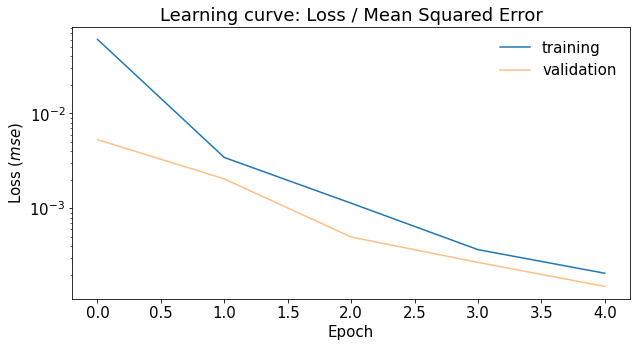

In [22]:
plt.rcParams.update({'font.size': 15})

fig, axs = plt.subplots(1,figsize=(10,5),facecolor="1")
axs.set_title('Learning curve: Loss / Mean Squared Error')
plt.plot(train_loss_history, label='training')
plt.plot(val_loss_history, label='validation',alpha=0.5)
axs.set_xlabel('Epoch'); axs.set_ylabel(f'Loss ($mse$)')
axs.set_yscale('log')
axs.legend(frameon=False);

### ML prediction of testing data

In [23]:
titlestr = np.array(['temperature','water vapor','cloud liquid','precipitation'])

### Plot predicted output 
* (in scaled form if applicable)

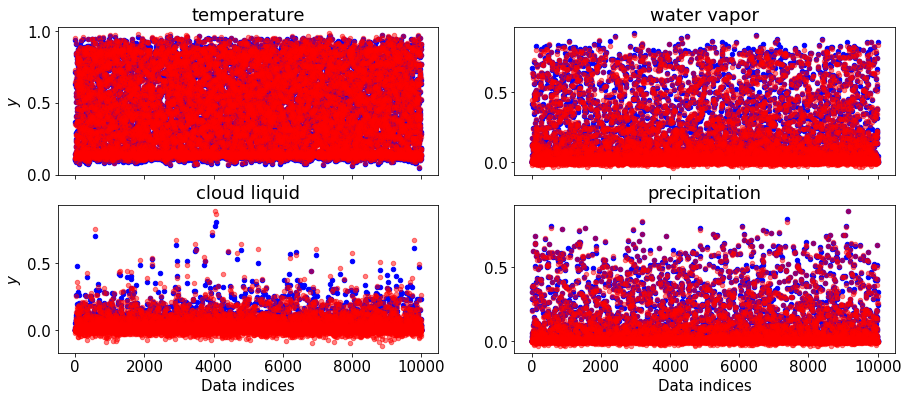

In [24]:
fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(np.arange(1,test_OP.shape[0]+1),test_OP[:,i],color='blue',s=20)
    axs[i].scatter(np.arange(1,test_OP.shape[0]+1),test_OP_ML[:,i],color='red',s=20,alpha=0.5)
    axs[i].set_title(r''+titlestr[i])
axs[2].set_xlabel(r'Data indices'); axs[3].set_xlabel(r'Data indices');
axs[0].set_ylabel(r'$y$'); axs[2].set_ylabel(r'$y$');

if saveFig: plt.savefig(f'{fname_Fig}_testOP_scaled.png', bbox_inches='tight',dpi=100)

### Correlation between true & predicted values

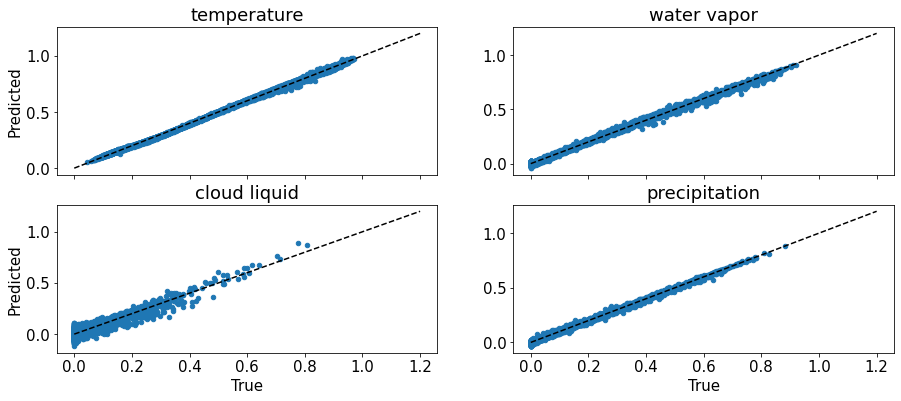

In [25]:
fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(test_OP[:,i],test_OP_ML[:,i],s=20)
    axs[i].plot(np.linspace(0,1.2),np.linspace(0,1.2),'--',color='k')
    axs[i].set_title(r''+titlestr[i])
axs[2].set_xlabel(r'True'); axs[3].set_xlabel(r'True');
axs[0].set_ylabel(r'Predicted'); axs[2].set_ylabel(r'Predicted');

if saveFig: plt.savefig(f'{fname_Fig}_testCorr_scaled.png', bbox_inches='tight',dpi=100)

### Plot re-scaled data

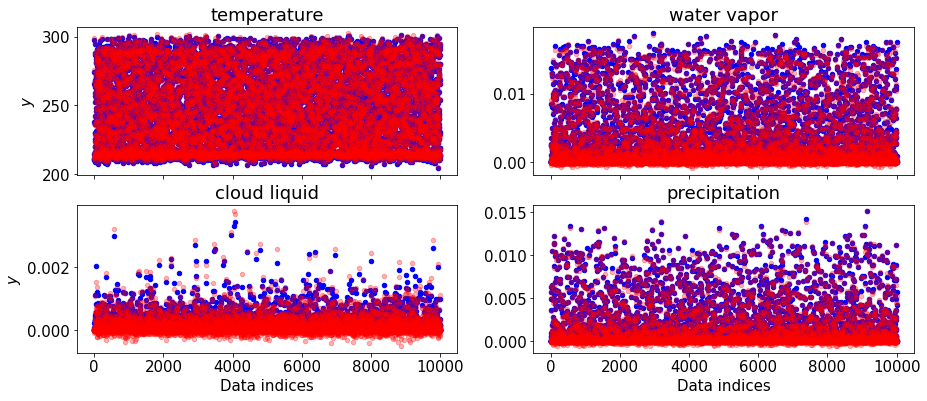

In [26]:
# get re-scaled data
test_OP_re = output_scalar.inverse_transform(test_OP)
test_OP_ML_re = output_scalar.inverse_transform(test_OP_ML)

fig, axs = plt.subplots(2,2,figsize=(15,6),sharex=True,facecolor="1")
axs = axs.ravel()
for i in range(4):
    axs[i].scatter(np.arange(1,test_OP_re.shape[0]+1),test_OP_re[:,i],color='blue',s=20)
    axs[i].scatter(np.arange(1,test_OP_re.shape[0]+1),test_OP_ML_re[:,i],color='red',s=20,alpha=0.3)
    axs[i].set_title(r''+titlestr[i])
axs[2].set_xlabel(r'Data indices'); axs[3].set_xlabel(r'Data indices');
axs[0].set_ylabel(r'$y$'); axs[2].set_ylabel(r'$y$');

### Error distribution

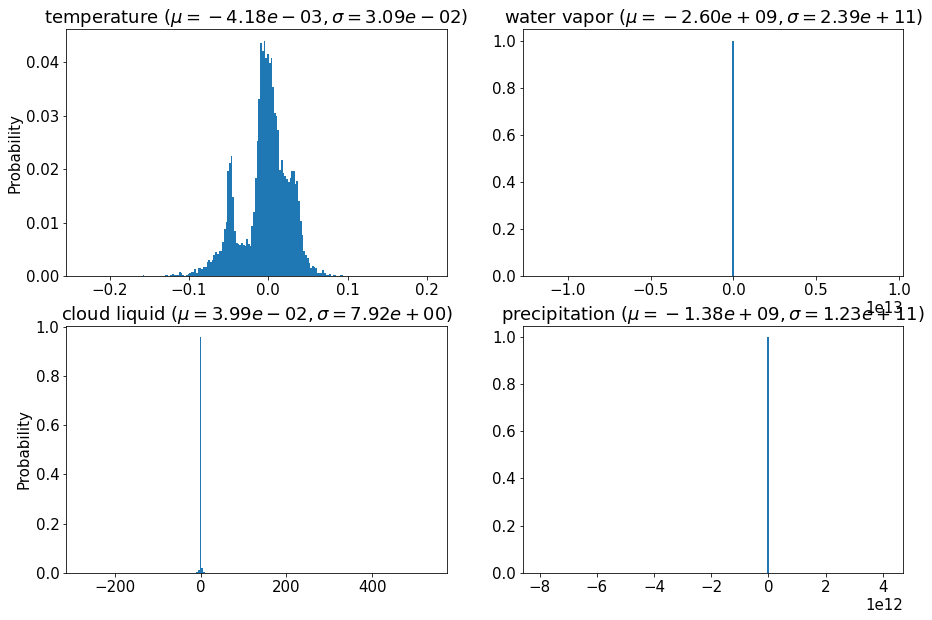

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10),facecolor="1")
axs = axs.ravel()
for i in range(4):
    err = (test_OP[:,i]-test_OP_ML[:,i]) / (test_OP[:,i] + 1e-15)
    err[test_OP[:,i]==0] = 0
    axs[i].hist(err, weights=np.ones(len(err)) / len(err),density=False, bins=200)
    axs[i].set_title(r''+titlestr[i]+' ($\mu = %4.2e , \sigma = %4.2e$)' % (np.mean(err),np.std(err)))
axs[0].set_ylabel('Probability');
axs[2].set_ylabel('Probability');
if saveFig: plt.savefig(f'{fname_Fig}_testOP_errI.png', bbox_inches='tight',dpi=200)

## Save model

* See [3_load_model_parameters.ipynb](3_load_model_parameters.ipynb) for samples on how to load the model

In [28]:
if device_name.type == 'cuda': model.to('cpu')   # for saving the model and plotting results

### For inference: Save serialized version of model's state dictionary (stat_dict)
* `model.stat_dict()` comprise of the learnable parameters of the model

In [29]:
if saveNN:
    modelpath = f'{fname_NN}_modelparameters.pkl'
    torch.save(model.state_dict(), modelpath)

# # How to load the model
# model = MLP(n_inputs,nneurons,leakyReLU_alpha,n_outputs)
# model.load_state_dict(torch.load(modelpath))
# model.eval()

* To save the full model for someone who does not have your code, use
```
torch.save(model, modelpath)
```

### For restart training: Save full model, optimizer, epoch, loss

In [30]:
if saveNN:
    modelpath = f'{fname_NN}_restart.tar'
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, modelpath)

# # How to load and restart training
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

# checkpoint = torch.load(modelpath)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()

#### Training & validation loss history

In [31]:
if saveNN:
    loss_history = np.append(np.asarray(train_loss_history).reshape(len(train_loss_history),1), 
                             np.asarray(val_loss_history).reshape(len(val_loss_history),1),axis=1)
    np.save(f'{fname_NN}_modelhist_epoch{str(nepoch)}_losshistory.npy',loss_history)

### For inference in C++ environment: Save model as TorchScript Format

In [32]:
if saveNN:
    # Make a separate dataloader for test dataset
    _, test_dl = prepare_data(test_IP, test_OP, 0.8, batch_size)
    # Load a sample image
    sample_input, sample_target = next(iter(test_dl))
    # run the tracing
    traced_script_module = torch.jit.trace(model, sample_input)  # NOTE:the model should be in cpu
    # save the converted model
    traced_script_module.save(f'{fname_NN}_Cpp.pt')